In [1]:
import typing as tp

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from sklearn.datasets import load_boston
from IPython.display import clear_output

/home/nkpalchikov/supportai_ml/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Генерация текстов -- начало

Презентация про RNN доступна по ссылке: https://docs.google.com/presentation/d/1tEvg1ozFFX_YzVBhCTR18fhmdsX51W4QgTaGzWRvkEE/edit?usp=sharing

Существуют блоки, созданные специально для обработки последовательностей, какой является текст. Можно сказать, что текст -- это последовательность символов, слов, подслов и так далее. Части, из которых состоит текст, называются *токенами*. А первым этапом при решении любой NLP задачи является токенизация.
Как правило, разным токенам сопоставляются их id -- числа.

**Задание 1** Дан файл Names.txt -- содержащий 55 тысяч индийских имён. Научимся же генерировать на их основе новые!

1) Прочитайте этот файлик и положите имена в список `all_names`
2) Сделайте из него три списка имён -- train, val и test -- разбейте файл в соотношении 0.8, 0.1, и 0.1 соответственно. Для этого подходит функция `train_test_split`из `sklearn`

In [48]:
<YOUR CODE>

In [49]:
assert set(train + test + val) == set(all_names)
assert abs(len(train) / len(all_names) - 0.8) <= 0.01
assert abs(len(test) / len(all_names) - 0.1) <= 0.01
assert abs(len(val) / len(all_names) - 0.1) <= 0.01

**Задание 2** Посчитайте два словарика -- `id2label` и `label2id`. Первый отображает айди токена (в данном случае токен = символ) в токен(символ). Второй словарик же просто обратен первому. Важно, что оба словаря должны быть построены на основе train, причём помимо символов оттуда должны содержаться следующие:
 - '$' -- этот символ будет обозначать начало последовательности, его id должен быть равен 2
 - '^' -- этот -- конец последовательности, его id должен быть равен 1
 - '_' -- этот -- отступ, позже будет объяснено зачем, его id должен быть равен 0

In [50]:
<YOUR CODE>

In [51]:
assert len(id2label) == len(label2id)
assert '_' in label2id
assert '$' in label2id
assert '^' in label2id
assert label2id['_'] == 0
assert label2id['$'] == 1
assert label2id['^'] == 2
for i in id2label:
    assert i == label2id[id2label[i]]


**Задание 3** Реализуйте функцию tokenize

In [52]:
def tokenize(name: str) -> tp.List[int]:
    """принимает на вход имя, возвращает список из айдишников токенов. Так же добавляет токен начала последовательности в начало
    и токен конца последовательности в конец
    """
    <YOUR CODE>
    

In [53]:
assert len(tokenize('hello')) == 7
assert len(tokenize('')) == 2

Теперь снова вернёмся к нейросетям. Наша цель -- научиться генерировать тексты.

#### Как генерировать тексты

Для этого обычно учат нейросеть по уже написанному куску текста предсказывать следующий токен. Таким образом, можно генерировать текст токен за токеном (сгенерировали следующий токен, дописали, то, что получилось -- подали сети на вход, и т.д., пока не сгенерируем конечный токен). Такая стратегия называется *жадной генерацией*.

**И это рассуждение очень опасно**
Если не вдаваться в подробности, то сгенерировав неправильные первые несколько токенов, нейросеть при дальнейшей генерации будет получать неправильный, плохой вход -- и как следствие, будет генерировать неправильный выход.
Вся логика следует из такой математики:

$$
p(x_1, x_2, \ldots, x_n) = p(x_n | x_{n - 1}, x_{n - 2}, \ldots, x_1) p(x_{n - 1} | x_{n - 2}, \ldots, x_1) \ldots p(x_1 | x_0) p(x_0)
$$

Слева -- вероятность всего предложения, $x_1, x_2, \ldots x_n$ -- его токены. Дело в том, что чтобы максимизировать эту вероятность (сделать предложение как можно более правдоподобным), совершенно необязательно оптимизировать множители справа налево. Вполне возможно, что оптимум будет при маленьком $p(x_0)$ -- сгенерированном втором символе, но при этом засчет него остальные множители будут огромны

В конце нашего недельного курса мы поговорим об эвристиках, как бороться с этой проблемой, ну а пока что остановимся на жадной генерации

#### Как сделать нейросеть, которая делает это
Несколько слов про рекуррентные нейронные сети. Естественно, всё уже реализованно в pytorch, поэтому рассмотрим на примере


![Image of Yaktocat](https://lena-voita.github.io/resources/lectures/text_clf/neural/rnn/general_cell-min.png)

In [54]:
# основа любой рекуррентной нейросети -- подобный блок
rnn_cell = nn.RNNCell(
    input_size=64,
    hidden_size=64,
)

In [55]:
initial_hidden_state = torch.zeros(1, 64)  # forward метод rnn-cell-а принимает некоторый вектор, называющийся состоянием
# сделаем его нулевым. Это состояние -- "память" нашего блока.
current_input = torch.ones(1, 64) # так rnn_cell принимает текущий input -- это признаки какого-нибудь токена

In [56]:
updated_hidden_state = rnn_cell(current_input, initial_hidden_state) 

RNN взял текущий вектор, взял предыдущие состояние своей "памяти" -- initial_hidden_state, и обновил это состояние, получили вектор updated_hidden_state -- обновленную память.
Таким образом, если у нас есть некоторая последовательность векторов, то мы можем обработать эту последовательность с помощью rnn_cell, учитывая порядок (по рекуррентности, в каждый момент времени updated_hidden_state будет содержать в себе информацию о векторах, которые мы уже обработали)

У нас сейчас есть последовательность токенов. Как можно заметить, это ни разу не векторы -- это последовательность чисел.
Но при этом для каждого уникального символа нет никаких проблем завести по отдельному вектору, после этого последовательность токенов превращать в последовательность векторов, просто беря для каждого токена соответствующий вектор.
Ровно этим и занимается модуль nn.Embedding

In [57]:
embeddings = nn.Embedding(3, 64)  # тут мы заводим 3 вектора размера 64. Это если бы всего уникальных токенов было 3, и их id были бы [0, 1, 2]

In [58]:
token_ids = torch.tensor([0, 1, 2]).unsqueeze(1)
token_embeddings = embeddings(token_ids) # а тут мы взяли для каждого токена соответствующий айдишник из таблицы
token_embeddings.shape 

torch.Size([3, 1, 64])

In [59]:
torch.allclose(token_embeddings[0], embeddings.weight[0]), torch.allclose(token_embeddings[1], embeddings.weight[1]), torch.allclose(token_embeddings[2], embeddings.weight[2])
# . ^--- убеждаемся в том, что этот модуль просто берет векторы с соответствующими индексами из таблички

(True, True, True)

In [60]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://lena-voita.github.io/resources/lectures/text_clf/neural/rnn/rnn_reads_text.mp4" frameborder="0" allowfullscreen></iframe>')

/home/nkpalchikov/supportai_ml/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Теперь, если мы эти три токена, и прочитаем их справа налево с помощью rnn_cell, то мы получим 3 hidden_state-а для первого, второго и третьего токенов. При этом
первый hidden_state учитывает только первый токен, второй -- первые два, а третий -- первые три, то есть всю последовательность. Так, с помощью rnn мы научились обрабатывать получать вектор для начала последовательности любого размера.

In [61]:
hidden_states = []
current_hidden_state = initial_hidden_state
for t in range(3):
    current_hidden_state = rnn_cell(token_embeddings[t], current_hidden_state)
    hidden_states.append(current_hidden_state)

In [62]:
hidden_states[0]  # эмбеддинг последовательности [0]
hidden_states[1]  # эмбеддинг последовательности [0, 1]
hidden_states[2]  # эмбеддинг последовательности [0, 1, 2]

tensor([[-0.7837,  0.8407, -0.2745, -0.1493, -0.4460,  0.7197, -0.2506,  0.0010,
          0.0961, -0.7175,  0.5508, -0.0834, -0.1324, -0.2036, -0.5617,  0.7192,
          0.0187,  0.4755, -0.3320, -0.2184,  0.8880, -0.6955, -0.6984,  0.8869,
          0.7881,  0.1389, -0.7269, -0.7416, -0.3496,  0.9009, -0.3774,  0.3920,
         -0.2197, -0.9028, -0.1793,  0.2232,  0.5920, -0.3861, -0.5051,  0.6581,
         -0.7186,  0.3915,  0.4986, -0.4193,  0.5367,  0.6992, -0.4717,  0.4857,
          0.6948, -0.5824,  0.4854,  0.3504, -0.2879,  0.7174,  0.1959, -0.9708,
          0.4016, -0.0591, -0.7237,  0.2113,  0.4515,  0.0097, -0.6487,  0.1707]],
       grad_fn=<TanhBackward0>)

In [63]:
all_hidden_states = torch.stack(hidden_states)

In [64]:
all_hidden_states.shape

torch.Size([3, 1, 64])

Циклы это не очень хорошо, но есть блок, который делает такой цикл за вас:

In [65]:
rnn = nn.RNN(input_size=64, hidden_size=64)

In [66]:
all_hidden_states, last_hidden_state = rnn(token_embeddings)

In [67]:
all_hidden_states.shape

torch.Size([3, 1, 64])

Держим в голове цель, нам надо предсказать следующий токен по предыдущим, то есть по некоторому началу последовательности нужно предсказать токен, который будет следующим.
Векторные представления таких "начал" разной длины мы научились предсказывать. Теперь остается только добавить классификатор, у которого количество классов будет равно количеству уникальных токенов. Если бы такое количество было равно трём, то классификатор мог бы выглядеть просто как-то так:

In [68]:
classifier = nn.Linear(64, 3)

In [69]:
output = classifier(all_hidden_states) # три распределения для каждой позиции -- что будет идти дальше
output.shape

torch.Size([3, 1, 3])

In [70]:
torch.softmax(output[0], dim=-1)  # "предикт" того, что будет идти на позиции 1 
torch.softmax(output[1], dim=-1)  # "предикт" того, что будет идти на  позиции 2
torch.softmax(output[2], dim=-1)  # "предикт" того, что будет идти на позиции 3

tensor([[0.2659, 0.3909, 0.3432]], grad_fn=<SoftmaxBackward0>)

А такой классификатор можно обучать с помощью кросс-энтропии.
В торче это тоже уже заимплеменчено
```
from torch.nn import F
loss = F.cross_entropy_loss(predicted, true, ... (тут можно еще передавать параметры, см. документацию))
```

Теперь соберем всё вместе и научимся генерировать имена :)

### Задание 3
Реализуйте функцию. Она нужна для того, чтобы потом батчами подавать слова, вычислять функцию потерь, делать шаг градиентного спуска (и так по кругу, как всегда)

In [71]:
def collate(names: tp.List[str]) -> torch.Tensor:
    """принимает на вход батч имён. Токенизирует их, и получившиеся списки токенов
    объединяет в тензор, предварительно дополнив каждый из них нулями (индексом токена _) при необходимости

    Для этого и пригодился токен _ -- чтобы можно было передавать последовательности разной длины в нейросеть
    для параллельной обработки

    возвращаемый тензор должен иметь размерность [максимальная длина, размер батча (len(names))]
    """
    <YOUR CODE>
    

In [72]:
output = collate(['hi', 'my', 'naame'])
assert output.shape == (7, 3)
assert output[-1][0] == 0
output = collate(['hi'])
assert output.shape == (4, 1)
assert output[-1] == 2
assert output[0] == 1

### Задание 4
Реализуйте простую RNN для генерации имён

In [73]:
class RNNNameGenerator(nn.Module):
    def __init__(
        self,
        number_of_unique_tokens: int,
        hidden_size: int, 
        embedding_size: int,
    ) -> None:
        super().__init__()
        self.embeddings = nn.Embedding(
            <YOUR CODE>
        )
        self.rnn = <YOUR CODE>
        self.classifier = <YOUR CODE>

    def forward(self, prefix_token_ids: torch.Tensor) -> torch.Tensor:
        """Генерирует предсказания следующих токенов для prefix_token_ids

        :param prefix_input_ids: тензор размера (максимальная длина в батче - 1, размер батча)
        :type prefix_input_ids: torch.Tensor
        :return: тензор размера (максимальная длина в батче - 1, размер батча, количество уникальных токенов)
            важно, что должны возвращаться логиты, то есть то, что ДО softmax
        :rtype: torch.Tensor
        """
        <YOUR CODE>

In [74]:
model = RNNNameGenerator(13, 32, 64)
output = model(torch.ones(24, 3).long())
assert output.shape == (24, 3, 13)
model = RNNNameGenerator(13, 32, 64)
output = model(torch.ones(24, 1).long())
assert output.shape == (24, 1, 13)

assert output[0].sum() != 1.0, "plz return logits, это то, что до софтмакса"

In [75]:
output.shape

torch.Size([24, 1, 13])

### Задание 5
Напишите лосс функцию

In [76]:
def calculate_loss_function(
    logits: torch.Tensor,
    true_labels: torch.Tensor
) -> torch.Tensor:
    """
    Считает кроссэнтропию, но усредненную только по позициям, где не символ '_'
    (считаем, что учить предсказывать этот символ бессмысленно)
    hint: используйте F.cross_entropy_loss c reduction='none', усредните лосс самостоятельно
    :param logits: of shape[max_len - 1, batch_size, num_unique_tokens]
    :type logits: torch.Tensor
    :param true_labels: of shape[max_len - 1, batch_size]
    :type true_labels: torch.Tensor
    """
    <YOUR CODE>

In [77]:
output = model(torch.ones(24, 3).long())
loss = calculate_loss_function(output, torch.ones(24, 3).long())
assert loss.shape == ()

Объявим вспомогательные классы для работы с даннными:

In [78]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, words: tp.List[str]):
        self.words = words

    def __len__(self): 
        return len(self.words)

    def __getitem__(self, idx):
        return self.words[idx]

In [79]:
train_dataset= Dataset(train)
val_dataset = Dataset(val)
test_dataset = Dataset(test)

In [80]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    collate_fn=collate,
)
val_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=False,
    collate_fn=collate,
    drop_last=True
)
test_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=False,
    collate_fn=collate,
    drop_last=True,
)

### Задание 6
Реализуйте функцию

In [81]:
def generate(model):
    current = [1]  # начинаем с токена "начало последовательности"
    while current[-1] != 2:
        out = <YOUR CODE>  # получаем вероятности символов следующего токена
        next = <YOUR CODE>  # сэмплируем этот токен пропорционально полученным вероятностям (torch.distributions.Categorical)
        current.append(next.item())
    
    return "".join([id2label[c] for c in current[1:-1]])


In [82]:
generate(model) # необученная генерация 

'$-CF CAAF.$AACAA'

In [83]:
n_epochs = 20
hidden_size = 64
embedding_size = 64

In [84]:
model = RNNNameGenerator(
    number_of_unique_tokens=len(id2label),
    hidden_size=hidden_size,
    embedding_size=embedding_size,
)
optimizer = torch.optim.Adam(model.parameters())

### Задание 7 
Всё вместе

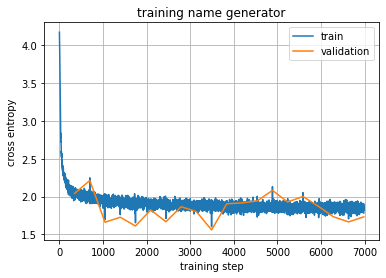

In [85]:
train_step = []
validation_step = []
train_loss_history = []
validation_loss_history = []
global_step = 0

for epoch in range(n_epochs):
    print(epoch)
    for train_batch in train_dataloader:
        # если хотим для каждого токена кроме последнего предсказать следующий, то что
        # здесь на вход модели, а что на выход? (не стесняйтесь просить хинты)
        x, y = <YOUR CODE>
        # считаем логиты
        <YOUR CODE>
        # считаем лосс
        <YOUR CODE>
        # backward шаг
        <YOUR CODE>
        # шаг оптимизатора и зануление старых градиентов
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        train_step.append(global_step)
        train_loss_history.append(loss.item()) 
    
    total_val_loss = 0.0
    for val_batch in val_dataloader:
        with torch.no_grad():
            x, y = <YOUR CODE>
            logits = model(x)
            loss = calculate_loss_function(logits, y)
            total_val_loss += loss.item()
    total_val_loss /= len(val_dataloader)
    validation_step.append(global_step)
    validation_loss_history.append(total_val_loss)

    clear_output()
    plt.plot(train_step, train_loss_history, label='train')
    plt.plot(validation_step, validation_loss_history, label='validation')
    plt.xlabel('training step')
    plt.ylabel('cross entropy')
    plt.title('training name generator')
    plt.grid()
    plt.legend()
    plt.show()
        


In [86]:
total_test_loss = 0.0
for test_batch in test_dataloader:
    with torch.no_grad():
        x, y = <YOUR CODE>
        logits = model(x)
        loss = calculate_loss_function(logits, y)
        total_test_loss += loss.item()
total_test_loss /= len(test_dataloader)


assert total_test_loss < 2

In [ ]:
print("Generated names")  # обученная генерация
for _ in range(20):
    print(generate(model))


## Бонус

Генерировать можно очень много чего, и на разных данных. Еще данные можно смешивать, и тогда получается особенно весело --
тексты выглядят как будто смесь из первых данных и вторых.
Например, можно обучиться на Льве Толстом и анекдотах :)

Здесь творческое задание, пожалуйста, творите :):)